## Импорты

In [825]:
import tensorflow as tf
import numpy as np
from finta import TA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, normalize
import sys
import glob
import pylab
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras_metrics import recall, precision, binary_precision, binary_recall
from sklearn.decomposition import PCA

## Препроцессинг, сигналы

In [60]:
def preprocess(fname, cut=0):
    print("preparing data...")
    df = pd.read_csv(fname)[-cut:]
    if '<DATE>' in df: df.pop('<DATE>')
    if '<TIME>' in df: df.pop('<TIME>')
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    signals = np.array(df["close"] - df["close"].shift() > 0).astype(int)[1:]
    df = df[:-1]
    indicators = df.copy()
    print("calculating indicators...")
    indicators['true_signals'] = signals
    indicators['KAMA'] = TA.KAMA(df)
    indicators['HMA'] = TA.HMA(df)
    indicators['TEMA5'] = TA.TEMA(df, period=5)
    indicators['TEMA20'] = TA.TEMA(df, period=20)
    indicators['EMA25'] = TA.EMA(df, period=25)
    indicators['EMA40'] = TA.EMA(df, period=40)
    indicators['BBWIDTH'] = TA.BBWIDTH(df)
    indicators['AO'] = TA.AO(df)
    indicators['RSI14'] = TA.RSI(df)
    indicators['RSI7'] = TA.RSI(df, period=7)
    indicators['RSI21'] = TA.RSI(df, period=21)
    #indicators['STC'] = TA.STC(df)
    indicators['ATR'] = TA.ATR(df)
    print("assigining indicators...")
    indicators = indicators.assign(**TA.EBBP(df))
    indicators = indicators.assign(**TA.KST(df))
    indicators = indicators.assign(**TA.EV_MACD(df))
    indicators.dropna(inplace=True)
    signals = np.array(indicators.pop('true_signals'))
    
    print("splitting data...")
    prices = indicators.close.copy()[WINDOW_SIZE-1:-1]
    indicators = pca.fit(indicators).transform(indicators)
    indicators = np.array([normalize(indicators[i:i+WINDOW_SIZE], axis=0, norm='max')
                  for i in range(len(indicators) - WINDOW_SIZE)])
    signals = signals[WINDOW_SIZE-1:-1]
    
    if len(indicators) != len(signals):
        raise RuntimeError("len(indicators) != len(signals)")
    if len(signals) != len(prices):
        raise RuntimeError("len(signals)(%s) != len(prices)(%s)" % (len(signals), len(prices)))
        
    split_index = int(TRAIN_TEST_SPLIT*len(prices))
    data_train, signals_train, prices_train = indicators[:split_index], signals[:split_index], prices[:split_index]
    data_test, signals_test, prices_test = indicators[split_index:], signals[split_index:], prices[split_index:]
    print("done!")
    
    return data_train, signals_train, prices_train, data_test, signals_test, prices_test

In [570]:
WINDOW_SIZE = 60
TRAIN_TEST_SPLIT = 0.92 # set to 0.1 for other stocks data testing
pca = PCA(12)
data_train, signals_train, prices_train, data_test, signals_test, prices_test = preprocess("./quotes/vtbr7.csv")

preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!


## Нейросеть

In [776]:
fl_filters = 4
conv_size = data_train.shape[-1]

i = Input(shape=(WINDOW_SIZE, conv_size))
conv2 = Reshape((WINDOW_SIZE, conv_size, 1))(i)
conv2 = Conv2D(fl_filters, (1, conv_size), padding='valid')(conv2)
conv2 = ReLU()(conv2)
conv2 = Reshape((WINDOW_SIZE, fl_filters))(conv2)
x = concatenate([i, conv2])
x = BatchNormalization()(x)
lstm = CuDNNLSTM(1, return_sequences=False)(x)
#lstm = CuDNNLSTM(4, return_sequences=False)(lstm)
x = Dropout(0.5)(x)
x = Conv1D(32, kernel_size=5)(x)
x = ReLU()(x)
x = MaxPool1D(2)(x)
x = Dropout(0.5)(x)
x = Conv1D(32, kernel_size=4)(x)
x = ReLU()(x)
x = MaxPool1D(2)(x)
x = Dropout(0.5)(x)
x = Conv1D(32, kernel_size=4)(x)
x = ReLU()(x)

#lstm = CuDNNLSTM(4, return_sequences=False)(lstm)
x = MaxPool1D(2)(x)
x = Dropout(0.5)(x)
x = Conv1D(16, kernel_size=3)(x)
x = ReLU()(x)
#x = BatchNormalization()(x)
#x = Flatten()(x)
#x = Dropout(0.3)(x)
#x = Dense(8)(x)
#x = ReLU()(x)
#x = concatenate([x, lstm])
#x = BatchNormalization()(x)
#x = Dense(16)(x)
#x = ReLU()(x)
#x = Dense(16)(x)
#x = ReLU()(x)
#x = CuDNNLSTM(4, return_sequences=True)(x)
x = CuDNNLSTM(4, return_sequences=False)(x)
x = concatenate([x, lstm])
x = BatchNormalization()(x)
o = Dense(1, activation='sigmoid')(x)


model = tf.keras.models.Model(inputs=i, outputs=o)
model.compile(optimizer=Adam(0.001, epsilon=1e-7), loss='binary_crossentropy', metrics=[precision(), recall(), 'accuracy'])

tracking <tf.Variable 'Variable_32:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_33:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_34:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_35:0' shape=() dtype=int32> fn


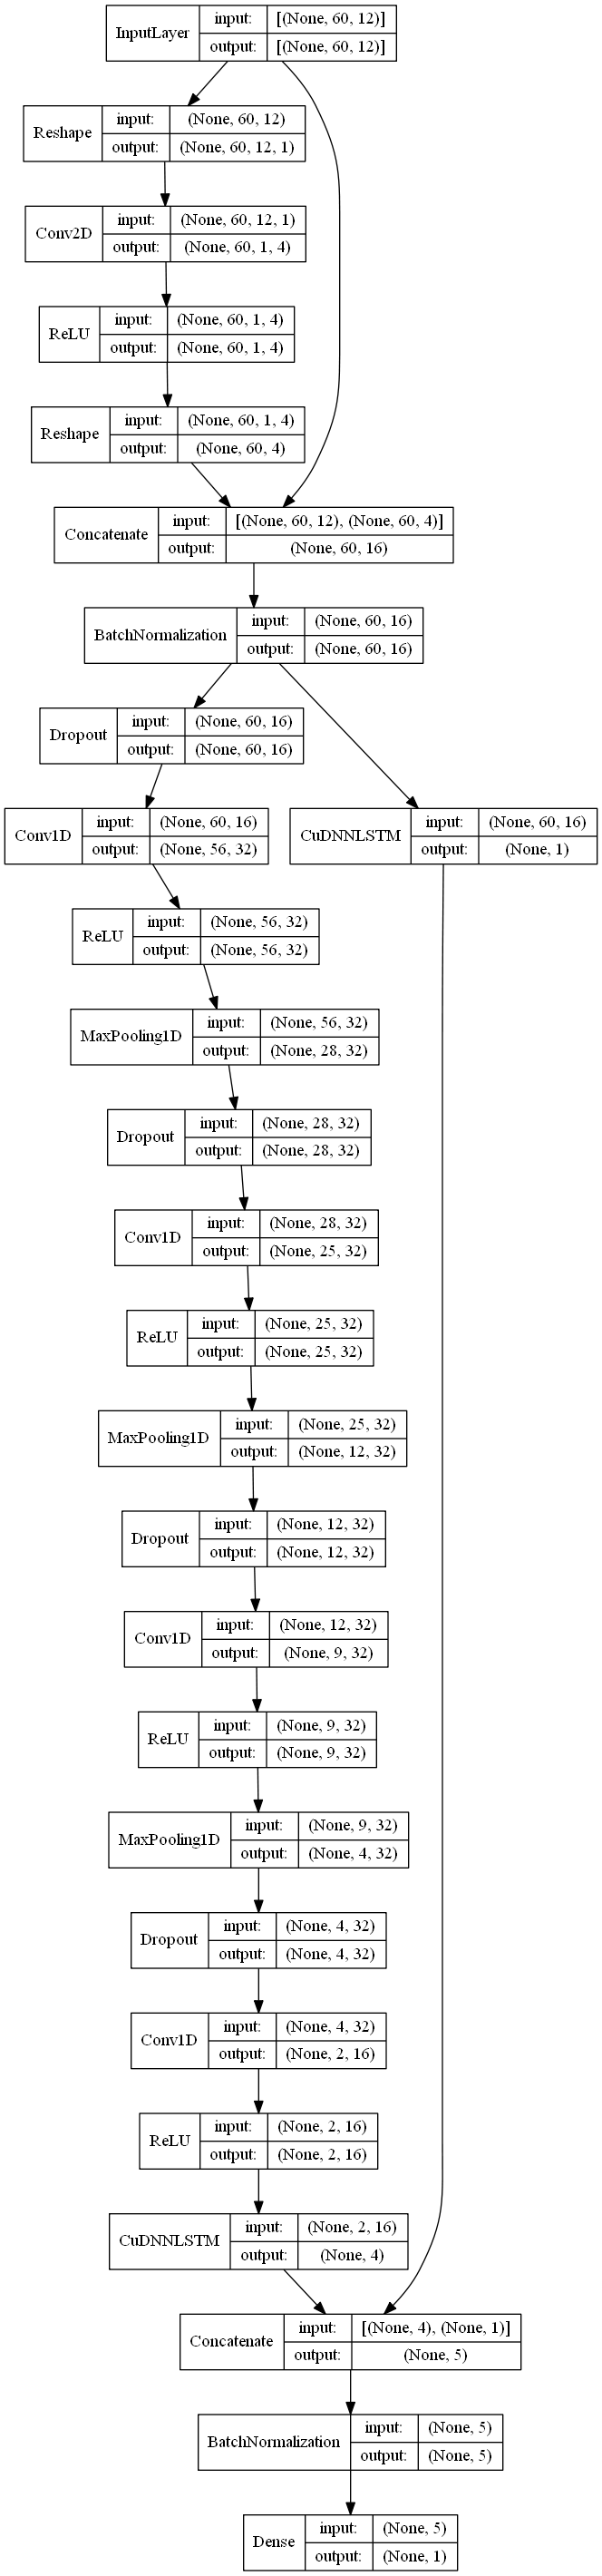

In [777]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='TB')

In [778]:
model.summary()

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 60, 12)]     0                                            
__________________________________________________________________________________________________
reshape_88 (Reshape)            (None, 60, 12, 1)    0           input_47[0][0]                   
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 60, 1, 4)     52          reshape_88[0][0]                 
__________________________________________________________________________________________________
re_lu_177 (ReLU)                (None, 60, 1, 4)     0           conv2d_44[0][0]                  
___________________________________________________________________________________________

## Обучение

In [785]:
model.fit(data_train, signals_train, epochs=400, validation_data=(data_test, signals_test), shuffle=False, batch_size=32)

Train on 39692 samples, validate on 3452 samples
Epoch 1/400
39692/39692 [==============================] - 43s 1ms/sample - loss: 0.6792 - precision: 0.5669 - recall: 0.4615 - acc: 0.5617 - val_loss: 0.6926 - val_precision: 0.5425 - val_recall: 0.2891 - val_acc: 0.5382
Epoch 2/400
39692/39692 [==============================] - 35s 877us/sample - loss: 0.6775 - precision: 0.5697 - recall: 0.4674 - acc: 0.5641 - val_loss: 0.6934 - val_precision: 0.5284 - val_recall: 0.2671 - val_acc: 0.5301
Epoch 3/400
39692/39692 [==============================] - 34s 868us/sample - loss: 0.6768 - precision: 0.5719 - recall: 0.4684 - acc: 0.5657 - val_loss: 0.6940 - val_precision: 0.5243 - val_recall: 0.2535 - val_acc: 0.5298
Epoch 4/400
 8864/39692 [=====>........................] - ETA: 28s - loss: 0.6791 - precision: 0.5759 - recall: 0.4378 - acc: 0.5619

KeyboardInterrupt: 

In [784]:
tf.keras.models.save_model(model, 'vtbr_hugebatch.h5')

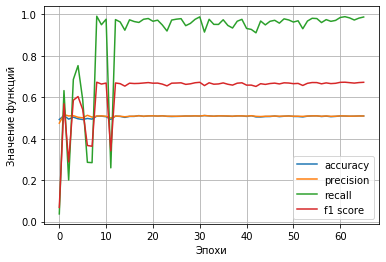

In [408]:
plt.plot(model.history.history['val_acc'], label='accuracy')
prec = model.history.history['val_precision']
plt.plot(prec, label='precision')
recall = model.history.history['val_recall']
plt.plot(recall, label='recall')
plt.plot(np.multiply(recall, prec)*2/(np.add(recall, prec)), label='f1 score')
plt.grid()
plt.xlabel('Эпохи')
plt.ylabel('Значение функций')
plt.legend()
plt.savefig('testing.png', dpi=600)

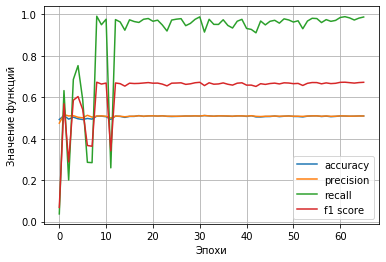

In [408]:
plt.plot(model.history.history['val_acc'], label='accuracy')
prec = model.history.history['val_precision']
plt.plot(prec, label='precision')
recall = model.history.history['val_recall']
plt.plot(recall, label='recall')
plt.plot(np.multiply(recall, prec)*2/(np.add(recall, prec)), label='f1 score')
plt.grid()
plt.xlabel('Эпохи')
plt.ylabel('Значение функций')
plt.legend()
plt.savefig('testing.png', dpi=600)

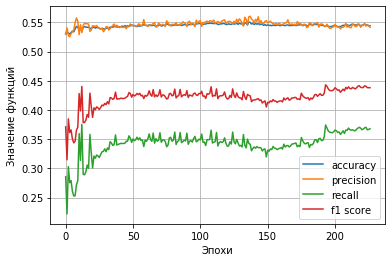

In [781]:
plt.plot(model.history.history['val_acc'], label='accuracy')
prec = model.history.history['val_precision']
plt.plot(prec, label='precision')
recall = model.history.history['val_recall']
plt.plot(recall, label='recall')
plt.plot(np.multiply(recall, prec)*2/(np.add(recall, prec)), label='f1 score')
plt.grid()
plt.xlabel('Эпохи')
plt.ylabel('Значение функций')
plt.legend()
plt.savefig('testing.png', dpi=600)

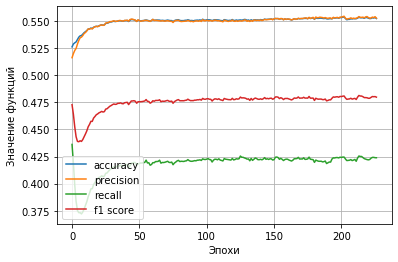

In [782]:
plt.plot(model.history.history['acc'], label='accuracy')
prec = model.history.history['precision']
plt.plot(prec, label='precision')
recall = model.history.history['recall']
plt.plot(recall, label='recall')
plt.plot(np.multiply(recall, prec)*2/(np.add(recall, prec)), label='f1 score')
plt.grid()
plt.xlabel('Эпохи')
plt.ylabel('Значение функций')
plt.legend()
plt.savefig('testing.png', dpi=600)

# Тесты 1Н

In [280]:
minutes_dirs = glob.glob("./quotes/*4.csv")
hours_dirs = glob.glob("./quotes/*7.csv")
days_dirs = glob.glob("./quotes/*8.csv")

In [943]:
SURE = 0.01
STOP = 0.1
TRAIN_TEST_SPLIT = 0.0
INITIAL_MONEY = 100000
COMISSION = 0.01/100
BROKER_COMISSION = 2
stop_loss = 0.6

def model_test(fname, data_test, dfcopy):
    sure = SURE
    money = 100000
    checkpoint = money
    cur_stocks = 0

    sells = []
    buys = []
    stats = []
    stops = []

    #preds = model.predict(data_test)
    preds = np.random.uniform(size=len(data_test))
    #print(preds)
    #preds = list(TA.SMA(pd.DataFrame(preds, columns=['close']), period=4).fillna(0.5))
    #preds = np.zeros((len(data_test),))
    temp_df = np.array(dfcopy.copy())
    #temp_df = temp_df[int(len(dfcopy)*TRAIN_TEST_SPLIT):].values
    for i, p in enumerate(preds):
        #print(cur_stocks, money)
        price = temp_df[i]
        """if price*cur_stocks + money < checkpoint*stop_loss:
            money -= BROKER_COMISSION
            n_stocks = -cur_stocks
            money += n_stocks*price
            cur_stocks += n_stocks
            print("stop loss", i, cur_stocks)"""
            
        if abs(p - 0.5) > sure:
            if p <= 0.5:
                #if cur_stocks > 0:
                    #print(i)
                n_stocks = INITIAL_MONEY // price + cur_stocks
                n_stocks *= 2
                if n_stocks > 0:
                    money -= BROKER_COMISSION
                    sells.append(i)
                    money += (n_stocks)*price*(1-COMISSION)
                    cur_stocks -= n_stocks
                #INITIAL_MONEY = price*cur_stocks + money
            else:
                n_stocks = (INITIAL_MONEY + money) // price
                if n_stocks > 0:
                    buys.append(i)
                    money -= BROKER_COMISSION
                    money -= n_stocks*price*(1+COMISSION)
                    cur_stocks += n_stocks
        elif abs(p - 0.5) < sure*STOP:
            if cur_stocks != 0:
                money += cur_stocks * price
                cur_stocks = 0
                stops.append(i)
        stats.append(price*cur_stocks + money)
        if price*cur_stocks + money > checkpoint: checkpoint = price*cur_stocks + money
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    fig.suptitle(fname, fontsize=20)
    axes[0].set_title("Зависимость стоимости акций (цена закрытия) от времени")
    axes[0].plot(temp_df)
    axes[0].plot(temp_df, '^', markersize=10, color='m', label = 'buying signal', markevery = buys, alpha=0.5)
    axes[0].plot(temp_df, 'v', markersize=10, color='k', label = 'selling signal', markevery = sells, alpha=0.5)
    axes[0].plot(temp_df, 'x', markersize=10, color='red', label = 'stopping signal', markevery = stops, alpha=0.8)
    #axes[0].plot(temp_df, '.', markersize=1, color='m', label = 'buying signal', markevery = buys, alpha=1)
    #axes[0].plot(temp_df, '.', markersize=1, color='k', label = 'selling signal', markevery = sells, alpha=1)
    axes[0].legend()
    axes[0].set_xlabel("Время")
    axes[0].set_ylabel("Цена закрытия")
    axes[0].grid()
    
    axes[1].set_title("Зависимость количества средств от времени")
    axes[1].plot(stats)
    axes[1].set_xlabel("Время")
    axes[1].set_ylabel("Всего средств")
    axes[1].grid()

    fig.tight_layout(pad=3)
    
def automated_test(fname, title, cut=0):
    data_train, signals_train, prices_train, data_test, signals_test, prices_test = preprocess(fname, cut=cut)
    model_test(title, data_test, prices_test)

## Графики для случайных данных

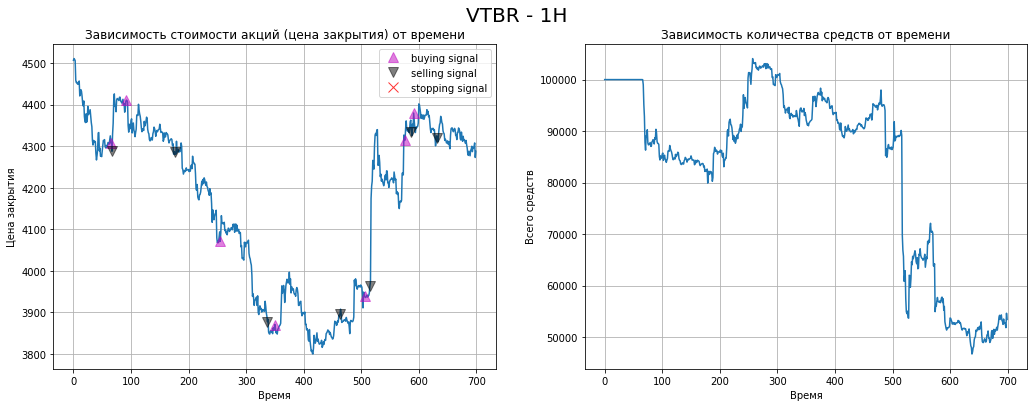

In [978]:
SURE = 0.48
STOP = 0.0
model_test('VTBR - 1H', data_test[900:1600], prices_test[900:1600])

## Несглаженные предсказания

Text(0.5, 1.0, 'Предсказания без SMA')

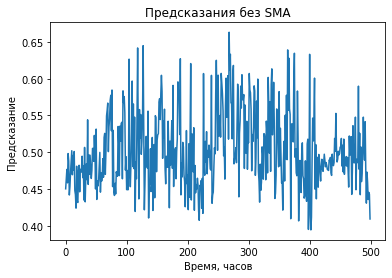

In [988]:
predis = model.predict(data_test[:500])
plt.plot(predis)
plt.xlabel('Время, часов')
plt.ylabel('Предсказание')
plt.title('Предсказания без SMA')

## Сглаженные предсказания

Text(0.5, 1.0, 'Предсказания с SMA10')

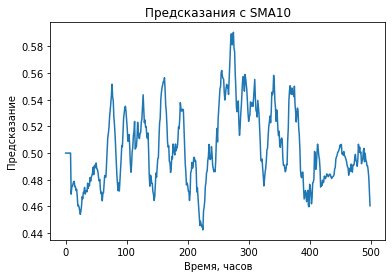

In [987]:
plt.plot(TA.SMA(pd.DataFrame(predis, columns=['close']), period=10).fillna(0.5))
plt.xlabel('Время, часов')
plt.ylabel('Предсказание')
plt.title('Предсказания с SMA10')

In [756]:
tf.keras.models.save_model(model, 'last.h5')

## Тестирование с остановкой

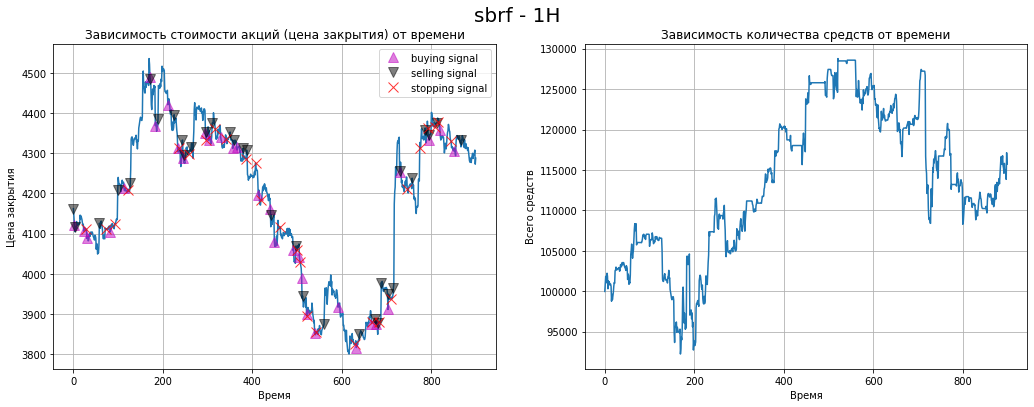

In [898]:
SURE = 0.06
STOP = 0.052
model_test('sbrf - 1H', data_test[700:1600], prices_test[700:1600])

## Выполнение всех предсказаний

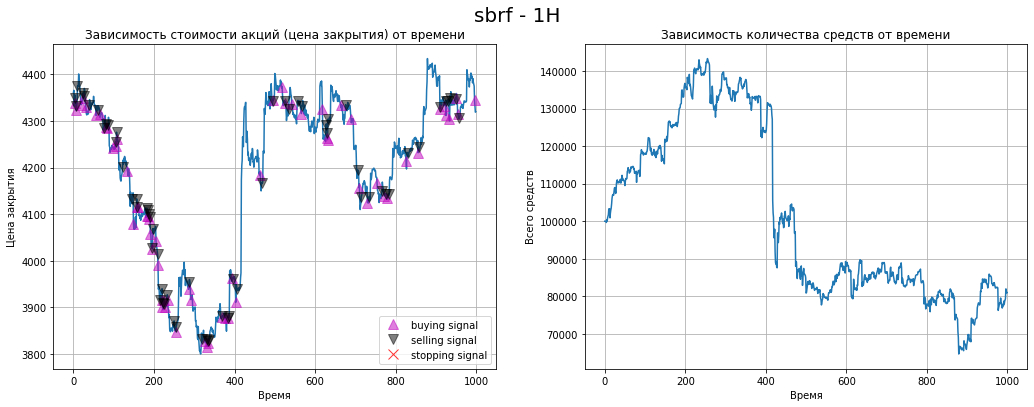

In [925]:
SURE = 0.0
STOP = 0.0
model_test('sbrf - 1H', data_test[1000:2000], prices_test[1000:2000])

## Только самые сильные сигналы

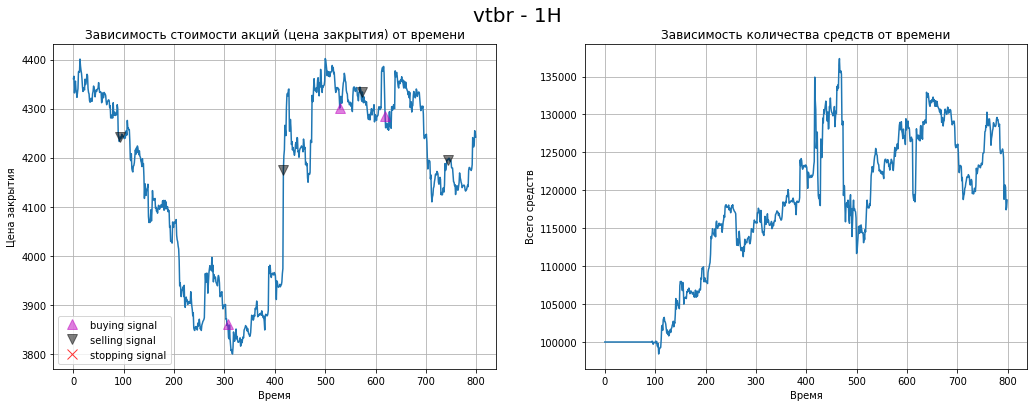

In [933]:
SURE = 0.065
STOP = 0.0
model_test('vtbr - 1H', data_test[1000:1800], prices_test[1000:1800])

## Только самые сильные сигналы -- весь год

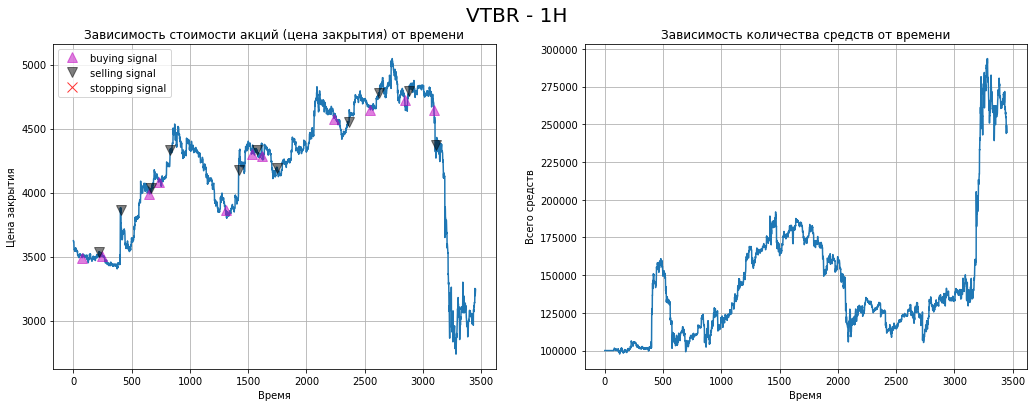

In [919]:
SURE = 0.065
STOP = 0.0
model_test('VTBR - 1H', data_test, prices_test)

In [828]:
model = tf.keras.models.load_model('vtbr_hugebatch.h5', custom_objects={'binary_precision': precision(), 'binary_recall': recall()})

tracking <tf.Variable 'Variable_38:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_39:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_40:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_41:0' shape=() dtype=int32> fn


## Тестирование на других акциях (не нужно)

preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!
preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!
preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!
preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!
preparing data...
calculating indicators...
assigining indicators...
splitting data...
done!


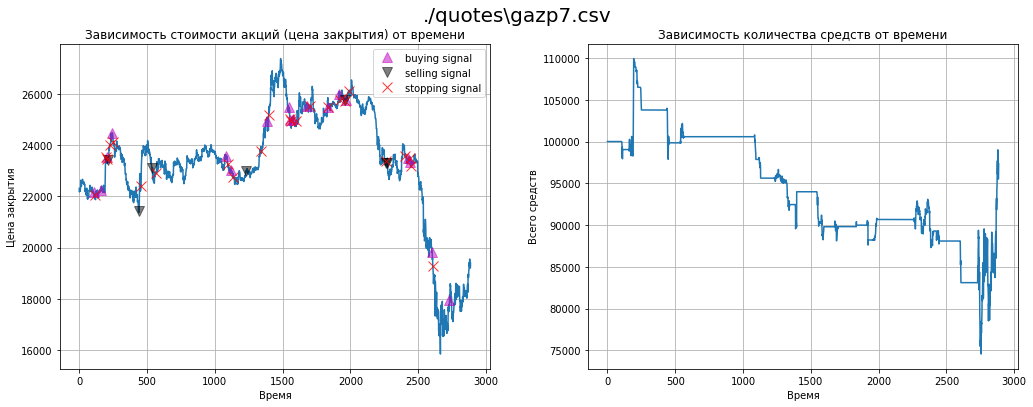

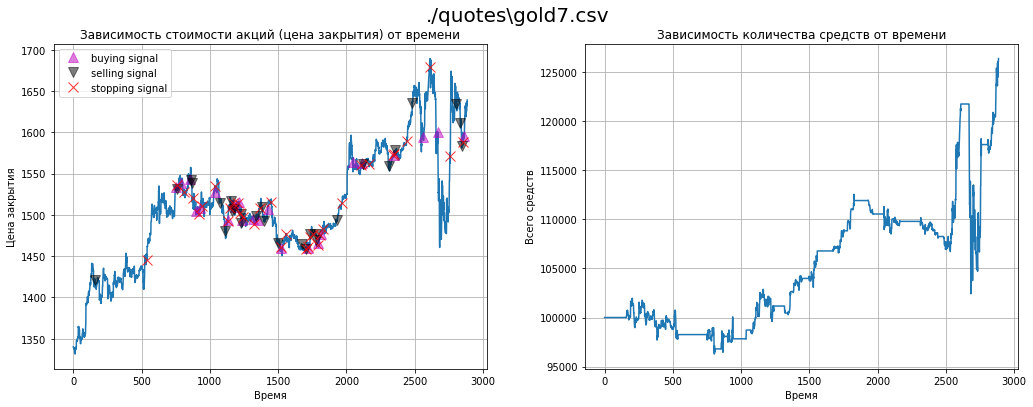

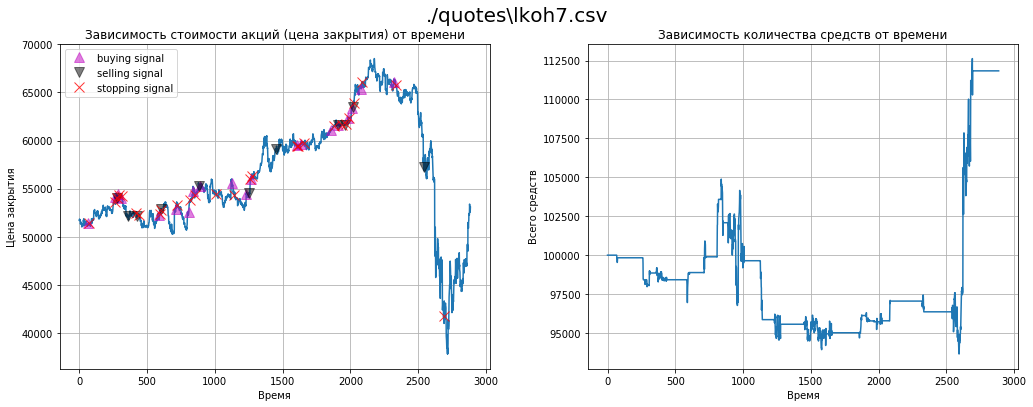

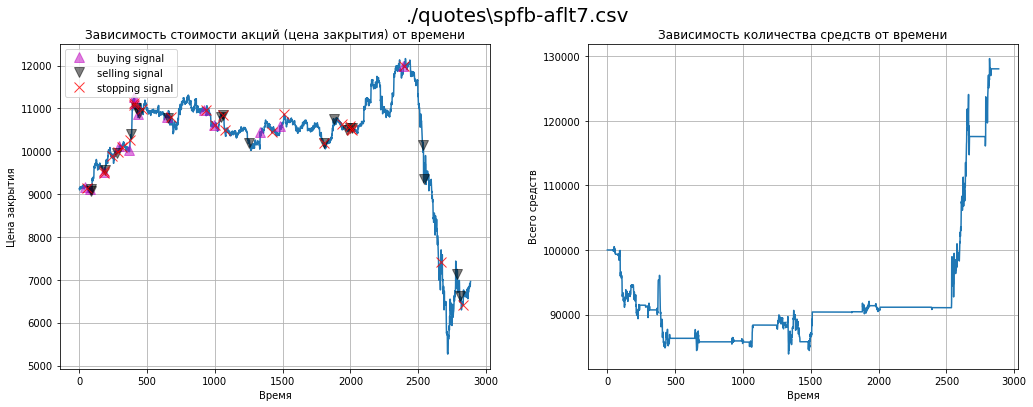

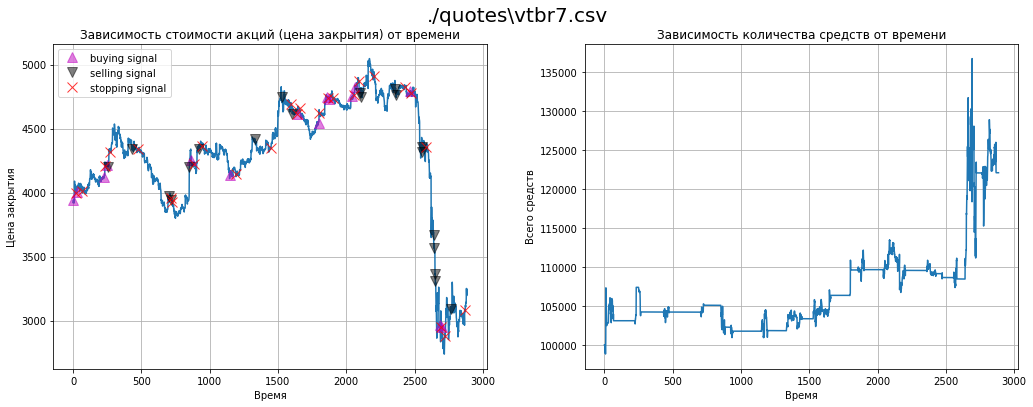

In [664]:
TRAIN_TEST_SPLIT = 0.0
SURE = 0.015
for p in hours_dirs:
    if 'sbrf7' not in p:
        automated_test(p, p, cut=3000)

In [19]:
df = pd.read_csv("./quotes/sbrf8.csv")

## Корреляция сигналов

In [990]:
if True:
    df = pd.read_csv('./quotes/vtbr8.csv')[:]
    if '<DATE>' in df: df.pop('<DATE>')
    if '<TIME>' in df: df.pop('<TIME>')
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    signals = np.array(df["close"] - df["close"].shift() > 0).astype(int)[1:]
    df = df[:-1]
    indicators = df.copy()
    print("calculating indicators...")
    indicators['true_signals'] = signals
    indicators['KAMA'] = TA.KAMA(df)
    indicators['HMA'] = TA.HMA(df)
    indicators['TEMA5'] = TA.TEMA(df, period=5)
    indicators['TEMA20'] = TA.TEMA(df, period=20)
    indicators['EMA25'] = TA.EMA(df, period=25)
    indicators['EMA40'] = TA.EMA(df, period=40)
    indicators['BBWIDTH'] = TA.BBWIDTH(df)
    indicators['AO'] = TA.AO(df)
    indicators['RSI14'] = TA.RSI(df)
    indicators['RSI7'] = TA.RSI(df, period=7)
    indicators['RSI21'] = TA.RSI(df, period=21)
    #indicators['STC'] = TA.STC(df)
    indicators['ATR'] = TA.ATR(df)
    print("assigining indicators...")
    indicators = indicators.assign(**TA.EBBP(df))
    indicators = indicators.assign(**TA.KST(df))
    indicators = indicators.assign(**TA.EV_MACD(df))
    indicators.dropna(inplace=True)
    signals = np.array(indicators.pop('true_signals'))

calculating indicators...
assigining indicators...


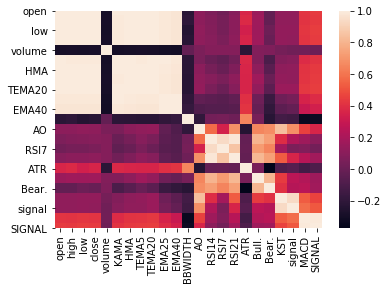

In [992]:
sns.heatmap(indicators.corr())

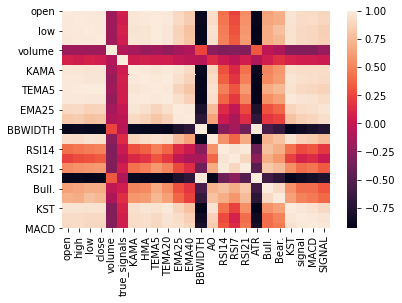

In [27]:
sns.heatmap(indicators.tail(100).corr())

## Корелляция после РСА

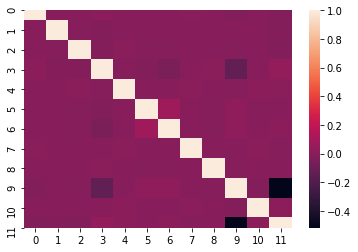

In [279]:
sns.heatmap(pd.DataFrame(data_train[:,-1]).corr())

Text(0, 0.5, 'Цена закрытия, руб')

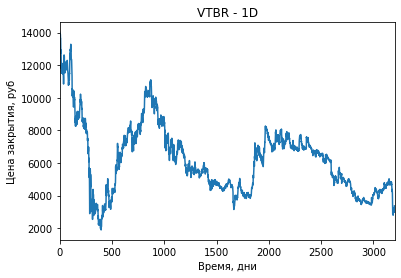

In [915]:
pd.read_csv('./quotes/vtbr8.csv')['<CLOSE>'].plot(title='VTBR - 1D')
plt.xlabel('Время, дни')
plt.ylabel('Цена закрытия, руб')